In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix, auc, roc_curve, roc_auc_score, average_precision_score

# from imblearn.over_sampling import RandomOverSampler, SMOTE

# measuring fairness
from fairlearn.metrics import (
    count,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    MetricFrame,
    make_derived_metric,
    selection_rate,  
)
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from random import sample


import warnings
warnings.filterwarnings("ignore")

In [2]:
compas_raw = pd.read_csv("compas-scores-two-years.csv")

In [3]:
compas_raw

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [4]:
compas_raw.isna().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [5]:
# filter similar to propublica
compas_drop = compas_raw[
    (compas_raw["days_b_screening_arrest"] <= 30)
    & (compas_raw["days_b_screening_arrest"] >= -30)
    & (compas_raw["is_recid"] != -1)
    & (compas_raw["c_charge_degree"] != "O")
    & (compas_raw["score_text"] != "N/A")
]
# select columns
compas_drop = compas_drop[["sex", "age", "race", "priors_count", 'c_charge_degree', "two_year_recid"]]
# cut-off score 5
# data["decile_score_cutoff"] = (data["decile_score"] >= 5).astype(int)
# inspect
compas_drop.head()

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,Male,69,Other,0,F,0
1,Male,34,African-American,0,F,1
2,Male,24,African-American,4,F,1
5,Male,44,Other,0,M,0
6,Male,41,Caucasian,14,F,1


In [6]:
compas_drop['race'].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian',
       'Native American'], dtype=object)

In [7]:
compas_bin = compas_drop[(compas_drop['race'] == 'African-American') | (compas_drop['race'] == 'Caucasian')]

In [8]:
compas_bin.reset_index(drop=True)

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,Male,34,African-American,0,F,1
1,Male,24,African-American,4,F,1
2,Male,41,Caucasian,14,F,1
3,Female,39,Caucasian,0,M,0
4,Male,27,Caucasian,0,F,0
...,...,...,...,...,...,...
5273,Male,30,African-American,0,M,1
5274,Male,20,African-American,0,F,0
5275,Male,23,African-American,0,F,0
5276,Male,23,African-American,0,F,0


In [9]:
compas_bin['two_year_recid'].value_counts()

0    2795
1    2483
Name: two_year_recid, dtype: int64

In [10]:
compas_bin.value_counts(['race', 'two_year_recid']).to_frame()

0
race             two_year_recid      
African-American 1               1661
                 0               1514
Caucasian        0               1281
                 1                822

In [11]:
data = compas_bin

## Base rate

In [12]:
# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(
    metrics={"base rate": selection_rate},
    y_true=data["two_year_recid"],  # y_true is ignored
    y_pred=data["two_year_recid"],
    sensitive_features=data["race"],
)
display(mf.by_group)

# summarize demographic parity as the max difference between groups
print("base rate diff: %.2f" % mf.difference(method="between_groups"))

,base rate
race,
African-American,0.52315
Caucasian,0.39087


base rate diff: 0.13


In [13]:
data_encoded = pd.get_dummies(data)

In [14]:
data['sex'] = (data['sex'] == 'Male').astype(int) # Male = 1, Female = 0

In [15]:
data['race'] = (data['race'] == 'Caucasian').astype(int) # Caucasian = 1, African-American = 0

In [16]:
data['c_charge_degree'] = (data['c_charge_degree'] == 'F').astype(int) # F = 1, M = 0

In [17]:
data.nunique() # Check if there are any other values

sex                 2
age                62
race                2
priors_count       36
c_charge_degree     2
two_year_recid      2
dtype: int64

In [18]:
data

,sex,age,race,priors_count,c_charge_degree,two_year_recid
1,1,34,0,0,1,1
2,1,24,0,4,1,1
6,1,41,1,14,1,1
8,0,39,1,0,0,0
10,1,27,1,0,1,0
...,...,...,...,...,...,...
7207,1,30,0,0,0,1
7208,1,20,0,0,1,0
7209,1,23,0,0,1,0
7210,1,23,0,0,1,0


In [19]:
y = data['two_year_recid']
X = data.drop(columns=['two_year_recid'])

In [20]:
# Train test split
rs = 0 # Random State

trainset, testset = train_test_split(data, test_size=0.25, random_state=rs)

In [21]:
crtr = trainset['two_year_recid'].sum() / len(trainset) # class rate in train set
print('Class rate in train set: %.4f' % crtr)

Class rate in train set: 0.4768


In [22]:
grtr = trainset['race'].sum() / len(trainset) # group rate in train set
print('Group rate in train set: %.4f' % grtr)

Group rate in train set: 0.3982


In [23]:
crte = testset['two_year_recid'].sum() / len(testset) # class rate in test set
print('Class rate in test set: %.4f' % crte)

Class rate in test set: 0.4515


In [24]:
grte = testset['race'].sum() / len(testset) # group rate in test set
print('Group rate in train set: %.4f' % grte)

Group rate in train set: 0.3992


## Naive oversampling

In [25]:
data00 = trainset[(trainset['race'] == 0) & (trainset['two_year_recid'] == 0)] # African-American, no recid
data01 = trainset[(trainset['race'] == 0) & (trainset['two_year_recid'] == 1)] # African-American, recid
data10 = trainset[(trainset['race'] == 1) & (trainset['two_year_recid'] == 0)] # Caucasian, no recid
data11 = trainset[(trainset['race'] == 1) & (trainset['two_year_recid'] == 1)] # Causacian, recid

In [26]:
datas = [data00, data01, data10, data11]

In [27]:
m = len(max(datas, key=len))

In [28]:
df = max(datas, key=len)
datass = [d for d in datas if d is not df]

In [29]:
for d in datass:
    # print(len(d))
    while len(d) < m - 100:
        d = d.append(d.sample(100))
    while len(d) < m:
        d = d.append(d.sample())
    # print(len(d))
    df = df.append(d)

In [30]:
# while len(data00) < m - 100:
#     data00 = data00.append(data00.sample(100))
# while len(data00) < m:
#     data00 = data00.append(data00.sample())
# print(len(data00))

In [31]:
# while len(data01) < m - 100:
#     data01 = data01.append(data01.sample(100))
# while len(data01) < m:
#     data01 = data01.append(data01.sample())
# print(len(data01))

In [32]:
# while len(data10) < m - 100:
#     data10 = data10.append(data10.sample(100))
# while len(data10) < m:
#     data10 = data10.append(data10.sample())
# print(len(data10))

In [33]:
# while len(data11) < m - 100:
#     data11 = data11.append(data11.sample(100))
# while len(data11) < m:
#     data11 = data11.append(data11.sample())
# print(len(data11))

In [34]:
# newdata = data00.append(data01).append(data10).append(data11)
newdata = df
newdata = newdata.reset_index(drop=True)

In [35]:
newdata

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,1,24,0,4,1,1
1,1,41,0,18,0,1
2,1,27,0,9,1,1
3,1,30,0,11,0,1
4,1,20,0,0,0,1
...,...,...,...,...,...,...
5063,1,46,1,7,1,1
5064,0,34,1,15,1,1
5065,1,25,1,4,1,1
5066,1,59,1,17,1,1


In [36]:
# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(
    metrics={"base rate": selection_rate},
    y_true=newdata["two_year_recid"],  # y_true is ignored
    y_pred=newdata["two_year_recid"],
    sensitive_features=newdata["race"],
)
display(mf.by_group)

# summarize demographic parity as the max difference between groups
print("base rate diff: %.2f" % mf.difference(method="between_groups"))

,base rate
race,
0,0.5
1,0.5


base rate diff: 0.00


In [37]:
newdata['two_year_recid'].sum() / len(newdata) #class imbalance

0.5

In [38]:
newdata['race'].sum() / len(newdata) #group imbalance

0.5

### Uncorrected data set

In [39]:
y_train1 = trainset['two_year_recid']
X_train1 = trainset.drop(columns=['two_year_recid'])

### Corrected data set

In [40]:
y_train2 = newdata['two_year_recid']
X_train2 = newdata.drop(columns=['two_year_recid'])

### Test set

In [41]:
y_test = testset['two_year_recid']
X_test = testset.drop(columns=['two_year_recid'])

## Model training

In [42]:
modelRG1 = RidgeClassifier(random_state=rs) # Logistic Regression Ridge


In [43]:
modelRG1.fit(X_train1, y_train1)

RidgeClassifier(random_state=0)

In [44]:
modelRG2 = RidgeClassifier(random_state=rs) # Logistic Regression Ridge
modelRG2.fit(X_train2, y_train2)

RidgeClassifier(random_state=0)

In [54]:
def print_metrics(modelRG):
    y_pred = modelRG.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    cr = classification_report(y_test, y_pred)
    print(cr)
    dis = ConfusionMatrixDisplay(cm)
    dis.plot(cmap='cividis', values_format='.0f')
    
    auc = roc_auc_score(y_test, y_pred)
    print('AUC score = %.2f' % auc)

    # compute metrics by group
    mf = MetricFrame(
        metrics={"selection rate (compas)": selection_rate},
        y_true=y_test,  # is ignored
        y_pred=y_pred,
        sensitive_features=X_test["race"],
    )

    # print results
    display(mf.by_group)
    print("Overall selection rate: %.2f" % mf.overall)

    # compute demographic parity as the max difference between groups
    print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

    # compute metrics
    mf = MetricFrame(
        metrics={
            "false positive rate": false_positive_rate,
            "false negative rate": false_negative_rate,
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test[["race"]],
    )
    display(mf.by_group)

    # print differences
    for i in mf.difference("between_groups").iteritems():
        print("%s diff: %.2f" % i)

    # alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
    dpd = equalized_odds_difference(
        y_test,
        y_pred,
        sensitive_features=X_test["race"],
        method="between_groups",
    )
    print("equalized odds diff: %.2f" % dpd)
    
    
    
def print_calib(modelRG):
    y_pp = modelRG.decision_function(X_test)
    
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for race in [0, 1]:
        prob_true, prob_pred = calibration_curve(
            y_true=y_test[X_test["race"] == race],
            y_prob=y_pp[X_test["race"] == race],
            n_bins=10,
            normalize=True,
        )
        plt.plot(prob_pred, prob_true, label=race)
    plt.title("Calibration Curves Compas scores")
    plt.xlabel("Mean Predicted Value")
    plt.ylabel("Proportion of Positives")
    plt.legend()
    plt.show()

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       724
           1       0.61      0.61      0.61       596

    accuracy                           0.65      1320
   macro avg       0.64      0.64      0.64      1320
weighted avg       0.65      0.65      0.65      1320

AUC score = 0.64


,selection rate (compas)
race,
0,0.578815
1,0.254269


Overall selection rate: 0.45
demographic parity difference: 0.32


,false positive rate,false negative rate
race,,
0,0.431078,0.271574
1,0.184615,0.633663


false positive rate diff: 0.25
false negative rate diff: 0.36
equalized odds diff: 0.36


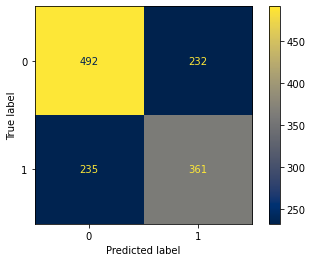

In [55]:
print_metrics(modelRG1)

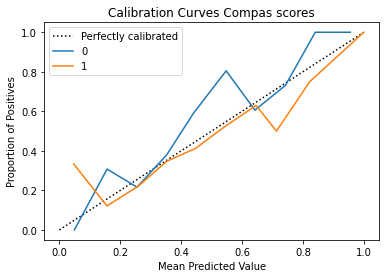

In [56]:
print_calib(modelRG1)

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       724
           1       0.61      0.63      0.62       596

    accuracy                           0.65      1320
   macro avg       0.65      0.65      0.65      1320
weighted avg       0.65      0.65      0.65      1320

AUC score = 0.65


,selection rate (compas)
race,
0,0.470366
1,0.455408


Overall selection rate: 0.46
demographic parity difference: 0.01


,false positive rate,false negative rate
race,,
0,0.293233,0.350254
1,0.369231,0.405941


false positive rate diff: 0.08
false negative rate diff: 0.06
equalized odds diff: 0.08


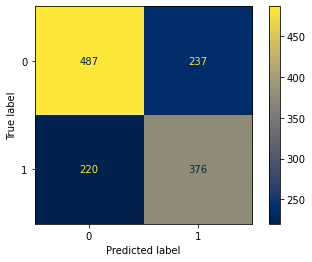

In [57]:
print_metrics(modelRG2)

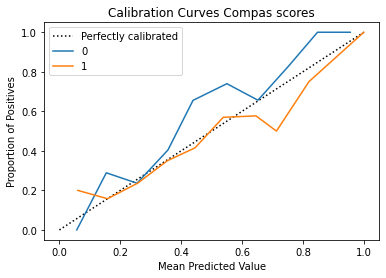

In [49]:
print_calib(modelRG2)